In [ ]:


!pip3 install opencv-contrib-python

In [ ]:
!pip3 install imutils




In [ ]:
!pip install opencv-python

In [ ]:
import cv2

In [ ]:
! pip install opencv-contrib-python

In [ ]:
import numpy as np
import pandas as pd
import cv2, os, re
import matplotlib.pyplot as plt
import imutils
!pip install opencv-python


from tqdm import tqdm
from imutils.object_detection import non_max_suppression

from tensorflow.keras.models import load_model

Selective Search is an algorithm that explores different segmentation hierarchies and combines them to generate region proposals. It starts with over-segmenting the image into small regions and gradually merges them based on color, texture, and other features. The resulting segments at different hierarchy levels serve as region proposals.

In [ ]:
def find_regions(image, method):

    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    if method == 'fast':
        ss.switchToSelectiveSearchFast()
    else:
        ss.switchToSelectiveSearchQuality()

    rects = ss.process()
    boxes = []
    for (x,y,w,h) in rects:

        boxes.append([x,y,w,h])
        pass

    return boxes
    pass

In [ ]:
scene_path = '/content/drive/MyDrive/Ships_dataset/scenes/scenes'

def load_scenes():

    scenes = []
    dirfiles = os.listdir(scene_path)
    dirfiles = sorted(dirfiles)
    for file in dirfiles:

        print(os.path.join(scene_path, file))
        scene = cv2.imread(os.path.join(scene_path, file))
        scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
        scenes.append(scene)
        pass

    return scenes
    pass

In [ ]:
scenes = load_scenes()

/content/drive/MyDrive/Ships_dataset/scenes/scenes/lb_1.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/lb_2.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/lb_3.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/lb_4.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/sfbay_1.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/sfbay_2.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/sfbay_3.png
/content/drive/MyDrive/Ships_dataset/scenes/scenes/sfbay_4.png


Applying SSA to each scene in scenes

In [ ]:
%%time
method = "fast"

boxes = []

for scene in scenes:

    box_in_scene = find_regions(scene, method)
    boxes.append(box_in_scene)
    pass

CPU times: user 22min 49s, sys: 1min 2s, total: 23min 52s
Wall time: 22min 49s


In [ ]:
!cp ship-model.h5 /content/drive/MyDrive

cp: cannot stat 'ship-model.h5': No such file or directory


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model


LOADING THE PRETRAINED MODEL USING TENSORFLOW KERAS API

In [ ]:
model = load_model('/content/drive/MyDrive/ship-model.h5')

model.summary()

Model: "Feature_Extraction_and_FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 58, 58, 3)         0         
 g2D)                                                            
                                                                 
 conv1 (Conv2D)              (None, 29, 29, 16)        448       
                                                                 
 bn_conv1 (BatchNormalizati  (None, 29, 29, 16)        64        
 on)                                                             
                                                                 
 conv_2A_branch2a (Conv2D)   (None, 29, 29, 32)        4640      
                                                                 
 bn_2A_branch2a (BatchNorma  (None, 29, 2

In [ ]:
from tqdm import tqdm


In [ ]:
%%time

rois, locs = [], []
images = []
for i,scene in tqdm(enumerate(scenes)):

    (H, W) = scene.shape[:2]
    region, loc = [],[]
    for (x,y,w,h) in boxes[i]:

        if w/float(W) > 0.10 and h/float(H) > 0.10:
            continue

        roi = scene[y:y+h,x:x+w]
        roi = cv2.cvtColor(roi,cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (48,48))

        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        pass

    preds = model.predict(np.array(rois,dtype=np.float32))
    preds = np.argmax(preds, axis=1)

    img = scene.copy()
    for (i,label) in enumerate(preds):

        if label == 1:
            (startX,startY,endX,endY) = locs[i]
            cv2.rectangle(img,(startX,startY),(endX,endY),(0,255,0),2)
        pass

    images.append(img)
    del rois[:]
    del locs[:]
    pass

0it [00:00, ?it/s]

202/202 [==============================] - 4s 21ms/step


1it [00:05,  5.90s/it]

118/118 [==============================] - 3s 24ms/step


2it [00:11,  5.71s/it]

313/313 [==============================] - 6s 19ms/step


3it [00:18,  6.34s/it]

225/225 [==============================] - 5s 24ms/step


4it [00:24,  6.33s/it]

399/399 [==============================] - 8s 21ms/step


5it [00:34,  7.51s/it]

314/314 [==============================] - 6s 20ms/step


6it [00:45,  8.83s/it]

216/216 [==============================] - 6s 27ms/step


7it [00:52,  8.09s/it]

113/113 [==============================] - 2s 19ms/step


8it [00:55,  6.91s/it]

CPU times: user 1min 3s, sys: 3.33 s, total: 1min 7s
Wall time: 55.3 s


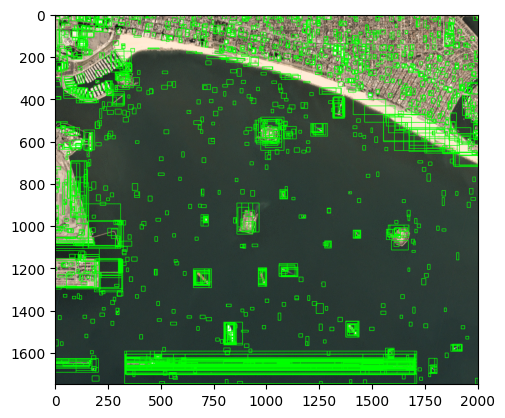

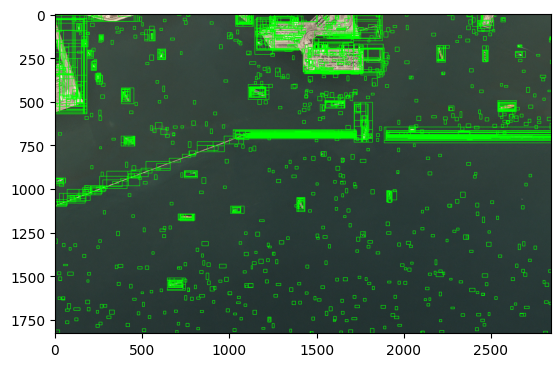

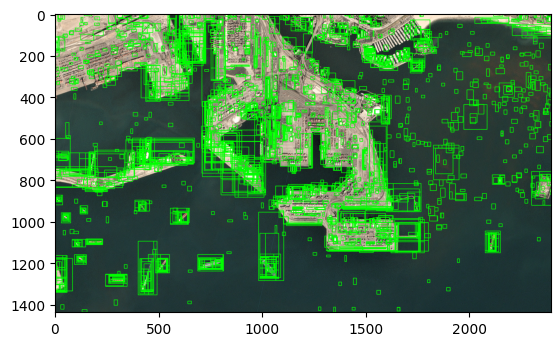

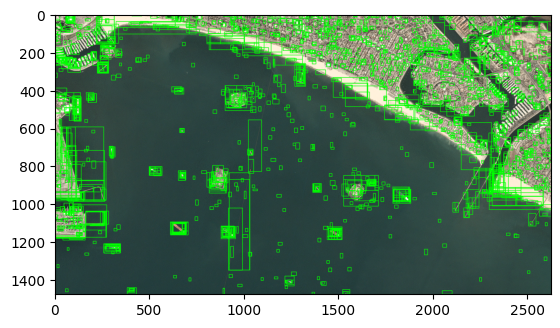

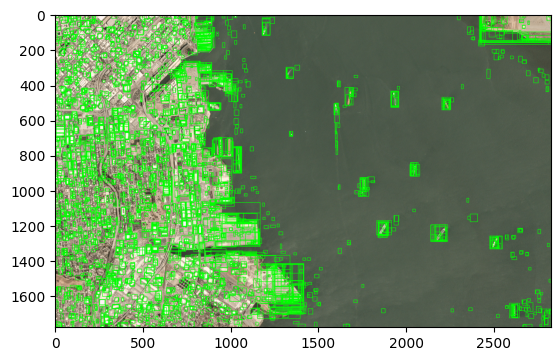

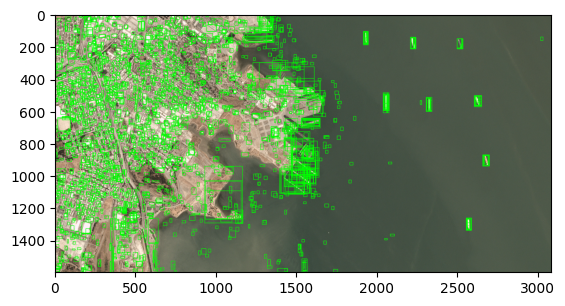

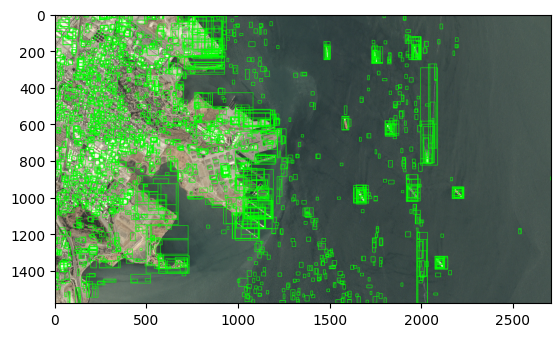

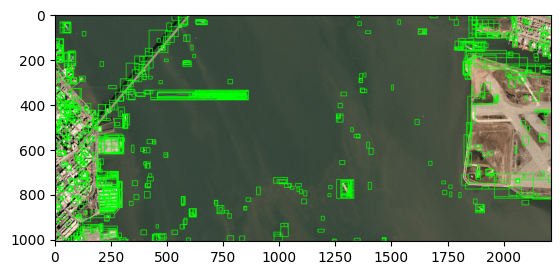

In [ ]:
for image in images:

    plt.imshow(image)
    plt.show();

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(None, None, 3))

# Region Proposal Network (RPN)
def rpn_layer(base_layers, num_anchors):
    x = layers.Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal')(base_layers)
    x = layers.Conv2D(num_anchors * 2, (1, 1), padding='valid', activation='linear', kernel_initializer='uniform')(x)

    # Reshape to (batch, height, width, num_anchors, 2)
    x = layers.Reshape((-1, 2))(x)

    return x

# ROI Pooling using tf.image.crop_and_resize
# ROI Pooling using tf.image.crop_and_resize
def roi_pooling(base_layers, rois, pool_size):
    pooled_rois = []
    for i in range(tf.shape(rois)[0]):
        # Extract bounding box coordinates from each ROI
        y1, x1, y2, x2 = tf.split(rois[i], 4)

        # Normalize coordinates to be within [0, 1]
        y1 /= tf.cast(tf.shape(base_layers)[1], dtype=tf.float32)
        x1 /= tf.cast(tf.shape(base_layers)[2], dtype=tf.float32)
        y2 /= tf.cast(tf.shape(base_layers)[1], dtype=tf.float32)
        x2 /= tf.cast(tf.shape(base_layers)[2], dtype=tf.float32)

        # Use tf.image.crop_and_resize
        pooled_roi = tf.image.crop_and_resize(
            base_layers,
            boxes=tf.stack([y1, x1, y2, x2], axis=-1),
            box_indices=tf.constant([i], dtype=tf.int32),
            crop_size=(pool_size, pool_size))
        pooled_rois.append(tf.expand_dims(pooled_roi, axis=0))
    return tf.concat(pooled_rois, axis=0)


# Fully Connected layer for classification and regression
def classifier_layer(base_layers, input_rois, num_classes, pool_size):
    x = layers.TimeDistributed(layers.Conv2D(1024, (7, 7), activation='relu', padding='valid'))(base_layers)
    x = layers.TimeDistributed(layers.Flatten())(x)
    x = layers.TimeDistributed(layers.Dense(4096, activation='relu'))(x)
    x = layers.TimeDistributed(layers.Dense(4096, activation='relu'))(x)

    # Classification layer
    classification = layers.TimeDistributed(layers.Dense(num_classes, activation='softmax'))(x)

    # Regression layer
    regression = layers.TimeDistributed(layers.Dense(num_classes * 4, activation='linear'))(x)

    return [classification, regression]

# Build Faster R-CNN model
def faster_rcnn_model():
    input_image = layers.Input(shape=(None, None, 3), name='input_image')
    input_rois = layers.Input(shape=(None, 4), name='input_roi')

    # Feature extraction using ResNet50
    base_layers = base_model(input_image)

    # Region Proposal Network (RPN)
    rpn = rpn_layer(base_layers, 9)

    # ROI Pooling
    pooled_rois = roi_pooling(base_layers, input_rois, 7)

    # Fully Connected layer for classification and regression
    output = classifier_layer(pooled_rois, input_rois, num_classes=2, pool_size=7)

    # Create the Faster R-CNN model
    model = Model(inputs=[input_image, input_rois], outputs=[rpn, output])

    return model

# Create Faster R-CNN model
faster_rcnn = faster_rcnn_model()

# Compile the model
faster_rcnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=[rpn_loss, 'categorical_crossentropy', 'mean_squared_error'])

# Display the summary of the model
faster_rcnn.summary()




TypeError: 'KerasTensor' object cannot be interpreted as an integer